# Scraping data from google play store for Lazada from 2021 onwards

In [ ]:
from google_play_scraper import reviews, Sort
from datetime import datetime
import pandas as pd

# Define a function to filter reviews from the year 2021 onwards in Singapore
def scrape_reviews_since_2021(app_id):
    all_reviews = []
    page_token = None
    year_threshold = 2021  # Set the year threshold

    while True:
        # Fetch reviews page by page
        review_batch, page_token = reviews(
            app_id,
            lang='en', 
            country='sg',
            sort=Sort.NEWEST,
            count=100,  # Fetch 100 reviews per batch for better efficiency
            continuation_token=page_token  # None for the first page
        )
        if not review_batch:
            break

        # Filter reviews from 2021 onwards
        for review in review_batch:
            review_date = datetime.utcfromtimestamp(review['at'].timestamp())
            if review_date.year >= year_threshold:
                all_reviews.append({
                    'review': review['content'],
                    'date': review['at'],
                    'rating': review['score'],
                    'userName': review['userName'],
                    'thumbsUp': review['thumbsUpCount']
                })
            else:
                # Exit if reviews are older than 2021
                return all_reviews  # Early exit

        # If there is no page token, exit the loop (we've reached the last page)
        if not page_token:
            break

    return all_reviews

# Example usage:
app_id = 'com.lazada.android'  # Replace with the actual app ID
reviews_from_2021_onwards = scrape_reviews_since_2021(app_id)

# Convert the reviews to a pandas DataFrame
df = pd.DataFrame(reviews_from_2021_onwards)

# Save the DataFrame to an Excel file
df.to_excel('play_store_reviews_since_2021_singapore.xlsx', index=False)

print("Reviews successfully saved to play_store_reviews_since_2021_singapore.xlsx")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

df = pd.read_excel("play_store_reviews_since_2021_singapore.xlsx")
df.head(3)

,review,date,rating,userName,thumbsUp
0,good apps lazada,2024-10-24 20:32:48,5,Amir Hossain,0
1,Michael Lumacadchona26,2024-10-24 20:04:06,5,Michael Lumacad,0
2,I'm satisfied,2024-10-24 19:53:13,5,Ernilo Soria,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377037 entries, 0 to 377036
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   review    376939 non-null  object        
 1   date      377037 non-null  datetime64[ns]
 2   rating    377037 non-null  int64         
 3   userName  377034 non-null  object        
 4   thumbsUp  377037 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 14.4+ MB


In [3]:
# Dropping rows with empty reviews
df.dropna(subset=['review'],inplace=True)

<Axes: xlabel='rating', ylabel='count'>

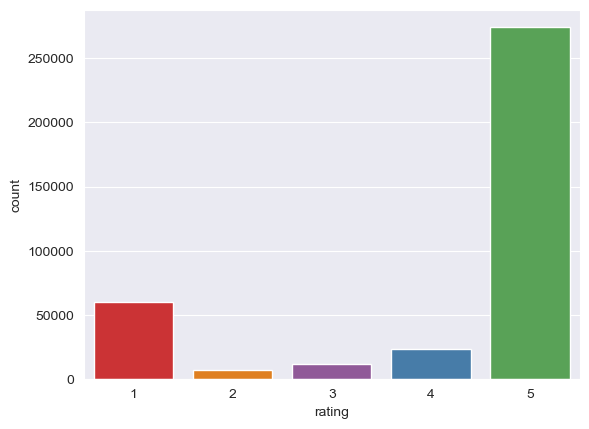

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
sns.countplot(data=df,x='rating', hue='rating',palette=['#e41a1c', '#ff7f00', '#984ea3','#377eb8', '#4daf4a'] ,legend=False)

# Time Analysis for years

In [5]:
df['year'] = df['date'].dt.year

In [6]:
df.year.value_counts()

year
2021    159153
2022    102211
2023     61823
2024     53752
Name: count, dtype: int64

<Axes: xlabel='year', ylabel='count'>

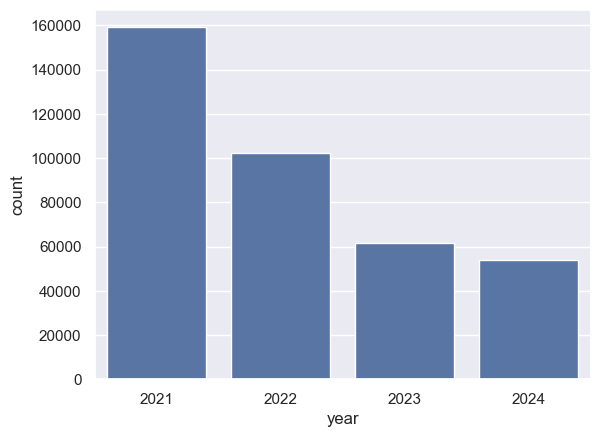

In [27]:
sns.countplot(df,x='year')   # Might not need to use 

In [8]:
rating_count = df.groupby(['year', 'rating']).size().reset_index().rename(columns={0:'count'})
rating_count

,year,rating,count
0,2021,1,24757
1,2021,2,3075
2,2021,3,5236
3,2021,4,10772
4,2021,5,115313
5,2022,1,15919
6,2022,2,1846
7,2022,3,2989
8,2022,4,6026
9,2022,5,75431


In [9]:
rating_count.pivot(index='year', columns='rating', values='count')

rating,1,2,3,4,5
year,,,,,
2021,24757,3075,5236,10772,115313
2022,15919,1846,2989,6026,75431
2023,10241,1434,2039,3764,44345
2024,9306,1108,1523,2781,39034


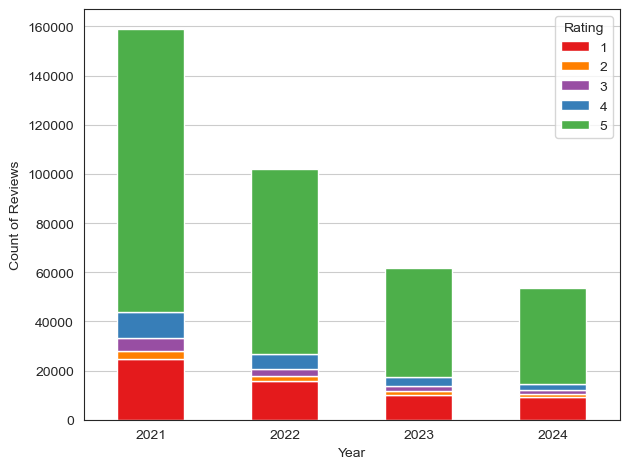

In [10]:
# Pivot the data so that we have a column for each rating
sns.set_style("white")

colors = ['#e41a1c', '#ff7f00', '#984ea3','#377eb8', '#4daf4a'] 
rating_pivot = rating_count.pivot(index='year', columns='rating', values='count')

# Plot the stacked bar chart
ax = rating_pivot.plot(kind='bar', stacked=True,color=colors)

plt.xlabel('Year')
plt.ylabel('Count of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Rating', loc='upper right')
plt.tight_layout()

# Add numbers on top of the bars
# for container in ax.containers:
#     ax.bar_label(container, label_type='center', fmt='%d')

plt.tight_layout()
plt.grid(axis = 'y')

# Show the plot
plt.show()

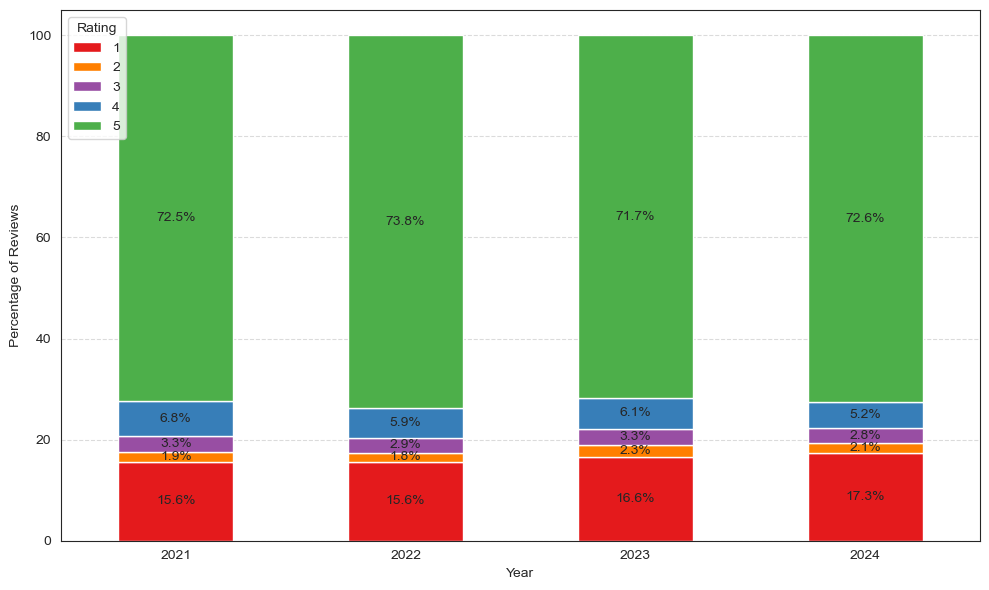

In [11]:
import matplotlib.pyplot as plt

colors = ['#e41a1c', '#ff7f00', '#984ea3','#377eb8', '#4daf4a'] 
# Calculate the percentage for each rating within each year and reset index for alignment
rating_count['percentage'] = rating_count.groupby('year')['count'].apply(lambda x: x / x.sum() * 100).reset_index(drop=True)

# Pivot the data to prepare for plotting percentages
rating_pivot = rating_count.pivot(index='year', columns='rating', values='percentage')

# Plot the stacked bar chart with percentage values
ax = rating_pivot.plot(kind='bar', stacked=True, figsize=(10, 6),color=colors)

plt.xlabel('Year')
plt.ylabel('Percentage of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Rating', loc='upper left')
plt.tight_layout()

# Add percentage labels on top of the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%.1f%%')  # Display as percentages

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


# Sentiment Analysis to show if the rating aligns

In [17]:
import nltk

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Valentino
[nltk_data]     Ong\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [8]:
review_list = df['review'].to_list()
neg_list = []
neu_list = []
pos_list = []
compound_list = []
for review in review_list:
    scores = analyzer.polarity_scores(review)
    neg_list.append(scores['neg'])
    neu_list.append(scores['neu'])
    pos_list.append(scores['pos'])
    compound_list.append(scores['compound'])

df['neg'] = neg_list
df['neu'] = neu_list
df['pos'] = pos_list
df['compound'] = compound_list

df.head(2)

,review,date,rating,userName,thumbsUp,year,neg,neu,pos,compound
0,good apps lazada,2024-10-24 20:32:48,5,Amir Hossain,0,2024,0.0,0.408,0.592,0.4404
1,Michael Lumacadchona26,2024-10-24 20:04:06,5,Michael Lumacad,0,2024,0.0,1.000,0.000,0.0000


In [33]:
def classify_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else: return 'neutral'

df['sentiment'] = df['compound'].apply(classify_sentiment)
df['sentiment'].value_counts()

sentiment
positive    230037
neutral     106430
negative     40472
Name: count, dtype: int64

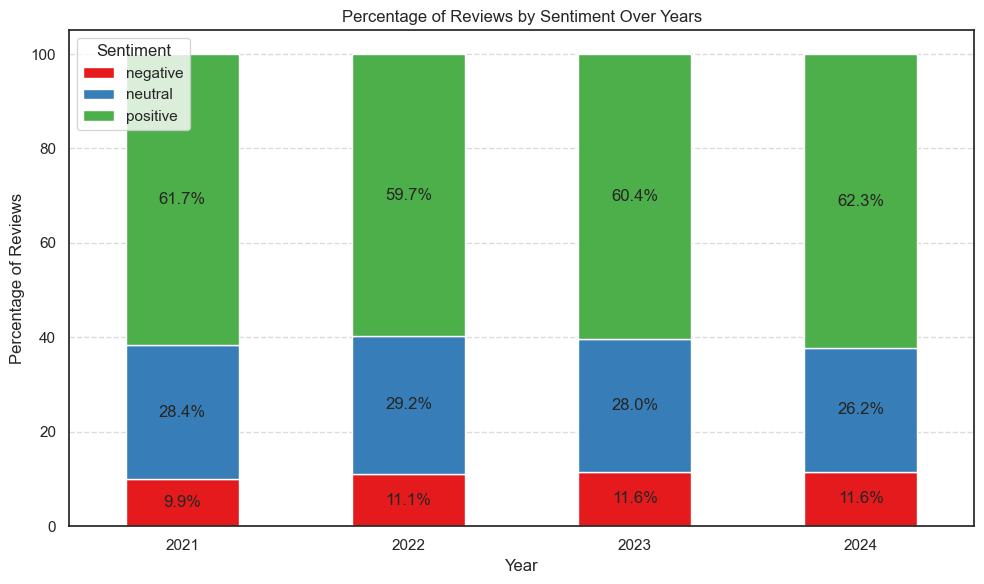

In [34]:
import matplotlib.pyplot as plt

# Example colors for sentiments: negative (red), positive (green), neutral (blue)
colors = ['#e41a1c', '#377eb8', '#4daf4a']  

# Calculate the percentage for each sentiment within each year and reset index for alignment
df['count'] = 1  # Add a count column for each review
sentiment_count = df.groupby(['year', 'sentiment']).count().reset_index()

# Calculate the percentage for each sentiment within each year
sentiment_count['percentage'] = sentiment_count.groupby('year')['count'].apply(lambda x: x / x.sum() * 100).reset_index(drop=True)

# Pivot the data to prepare for plotting percentages
sentiment_pivot = sentiment_count.pivot(index='year', columns='sentiment', values='percentage')

# Plot the stacked bar chart with percentage values for sentiments
ax = sentiment_pivot.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Percentage of Reviews')
plt.title('Percentage of Reviews by Sentiment Over Years')
plt.xticks(rotation=0)
plt.legend(title='Sentiment', loc='upper left')
plt.tight_layout()

# Add percentage labels on top of the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center', fmt='%.1f%%')  # Display as percentages

# Add gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Yes, both graphs support each other well and provide a comprehensive view of the review trends over time. Here’s an analysis of how they align and what insights they offer together:

### 1. Rating Distribution (First Graph)
The first graph shows the distribution of reviews by star rating (1-5) from 2021 to 2024:

The majority of reviews (around 70%) each year are 5-star ratings, which suggests that most users are satisfied with the product/service.
There is a consistent portion of 1-star ratings (between 15-17% each year), showing some dissatisfaction.
Ratings in between (2 to 4 stars) make up a smaller percentage, indicating that users tend to have polarized opinions (very satisfied or dissatisfied).
### 2. Sentiment Distribution (Second Graph)
The second graph classifies these reviews into sentiments: positive, neutral, and negative:

Positive sentiment dominates each year, aligning with the high proportion of 5-star ratings in the first graph.
Neutral sentiment remains fairly stable, similar to the 4-star and 3-star ratings in the first graph.
Negative sentiment mirrors the 1-star rating trend, with a slightly increasing trend in negative sentiment from 2021 to 2024.
### Combined Interpretation
Both graphs indicate that the majority of reviews are positive, but there is a noticeable, consistent proportion of negative feedback:

The high percentage of positive sentiment corresponds well with the high number of 5-star ratings.
The stable but slightly rising trend in negative sentiment aligns with the proportion of 1-star ratings over the years.
Summary for Presentation
You could conclude that both graphs support each other by illustrating a high level of customer satisfaction but with a consistent, underlying level of dissatisfaction. This consistency suggests that while most customers are happy, there are recurring issues that some users find frustrating, which is evident in both low ratings and negative sentiment. Addressing these issues could help further improve the overall customer satisfaction trend.

# Analysis is carried out with respsect to rating over Sentiment

Certainly! Here’s an explanation of why conducting analysis using ratings might be preferable to relying solely on sentiment analysis and why it aligns with a more people-centered approach:

### 1. Ratings Reflect Direct User Judgement
Ratings are an explicit, straightforward measure of customer satisfaction or dissatisfaction, directly provided by users. They’re a clear expression of how customers judge the product or service, whereas sentiment analysis is an interpretation by a model that can sometimes misinterpret nuance.
By focusing on ratings, you respect the direct feedback that users intended to convey, rather than relying on potentially imperfect model interpretations. It’s essentially a way of following users’ own evaluations instead of an algorithm's assumptions.
### 2. Less Complexity and Interpretation Needed
Ratings don’t require interpretation in the way that sentiment scores do. While sentiment analysis models aim to predict the tone of a review, they can sometimes be inaccurate, especially with sarcastic or mixed reviews.
With ratings, the score is clear and requires no further inference or probability-based interpretation. It’s a straightforward measure that minimizes the risk of error from model limitations and reflects what the user intended to express in a more direct manner.
### 3. Quantitative Analysis is More Consistent
Ratings provide a consistent, quantitative value that’s easy to work with for statistical analysis, topic modeling, and trend tracking. They allow for easier comparisons, aggregations, and trend visualizations.
Sentiment analysis, on the other hand, introduces variability based on model performance and may produce inconsistent results across different texts. By focusing on ratings, your analysis benefits from the consistency of directly recorded user feedback.
### 4. Aligns Analysis with Real-World Perception
Users typically make purchasing decisions based on ratings rather than sentiment scores. By analyzing ratings, you align your insights with the same factors that influence actual consumer decisions.
Focusing on ratings allows you to capture this real-world impact directly. For example, a 4-star average rating can tell potential customers about the general quality of the product without needing to understand sentiment nuances.
### 5. Reflects Collective User Opinion, Not Model Interpretation
Using ratings respects the collective judgment of all users who left reviews. It’s a way to measure the product’s reputation as shaped by the community itself, rather than a sentiment model’s approximation of that sentiment.
This “community-driven” approach emphasizes that the analysis is based on actual user experiences and assessments, rather than any machine learning model’s interpretation of text. This can be especially valuable when presenting findings, as it grounds your conclusions in actual user scores.
### Conclusion
By basing analysis on ratings, you’re able to focus on the clear, direct judgments that customers provide. Ratings capture collective user opinions and allow you to respect the judgments of the people rather than relying on model-based interpretations, which may sometimes miss nuances. Following ratings helps ground your analysis in the real-world perceptions of users and aligns with the way they express their satisfaction. This approach ensures that insights are rooted in customer feedback and thus feel more reliable and intuitive.

# Time Analysis for 2024

In [26]:
df_2024 = df[df['year'] == 2024].copy()
df_2024['month'] = df_2024.date.dt.month
df_2024.head()

,review,date,rating,userName,thumbsUp,year,month
0,good apps lazada,2024-10-24 20:32:48,5,Amir Hossain,0,2024,10
1,Michael Lumacadchona26,2024-10-24 20:04:06,5,Michael Lumacad,0,2024,10
2,I'm satisfied,2024-10-24 19:53:13,5,Ernilo Soria,0,2024,10
3,nice,2024-10-24 19:41:21,5,rosemarie delacruz,0,2024,10
4,Great,2024-10-24 19:22:20,5,"Alcantara, Henry A.",0,2024,10


In [27]:
rating_count = df_2024.groupby(['month', 'rating']).size().reset_index().rename(columns={0:'count'})
rating_count

,month,rating,count
0,1,1,875
1,1,2,141
2,1,3,169
3,1,4,320
4,1,5,3925
5,2,1,772
6,2,2,104
7,2,3,140
8,2,4,285
9,2,5,3634


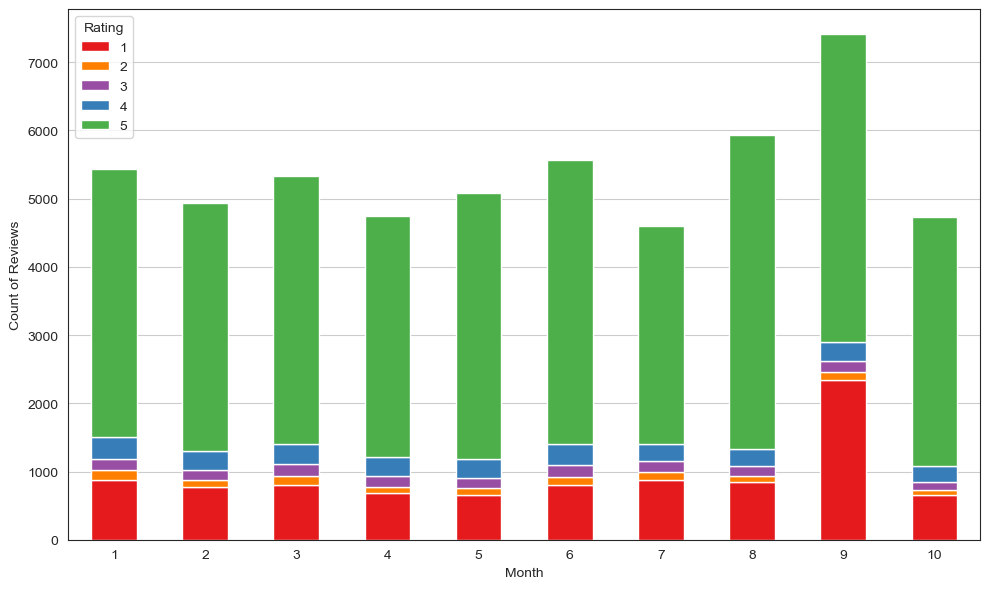

In [30]:
# Pivot the data so that we have a column for each rating
colors = ['#e41a1c', '#ff7f00', '#984ea3','#377eb8', '#4daf4a'] 
rating_pivot = rating_count.pivot(index='month', columns='rating', values='count')

# Plot the stacked bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))
rating_pivot.plot(kind='bar', stacked=True, color=colors,ax=ax1)

plt.xlabel('Month')
plt.ylabel('Count of Reviews')
plt.xticks(rotation=0)
plt.legend(title='Rating', loc='upper left')
plt.tight_layout()

# Add numbers on top of the bars
# for container in ax.containers:
#     ax.bar_label(container, label_type='center', fmt='%d')

plt.tight_layout()
plt.grid(axis = 'y')

# Show the plot
plt.show()

<Axes: xlabel='rating', ylabel='count'>

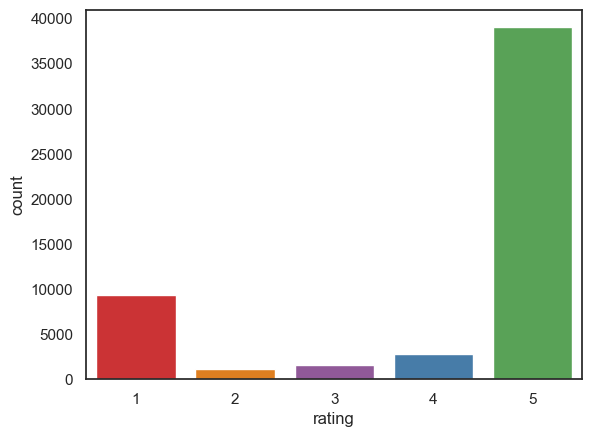

In [38]:
sns.countplot(data=df_2024,x='rating', hue='rating',palette= ['#e41a1c', '#ff7f00', '#984ea3','#377eb8', '#4daf4a'],legend=False)

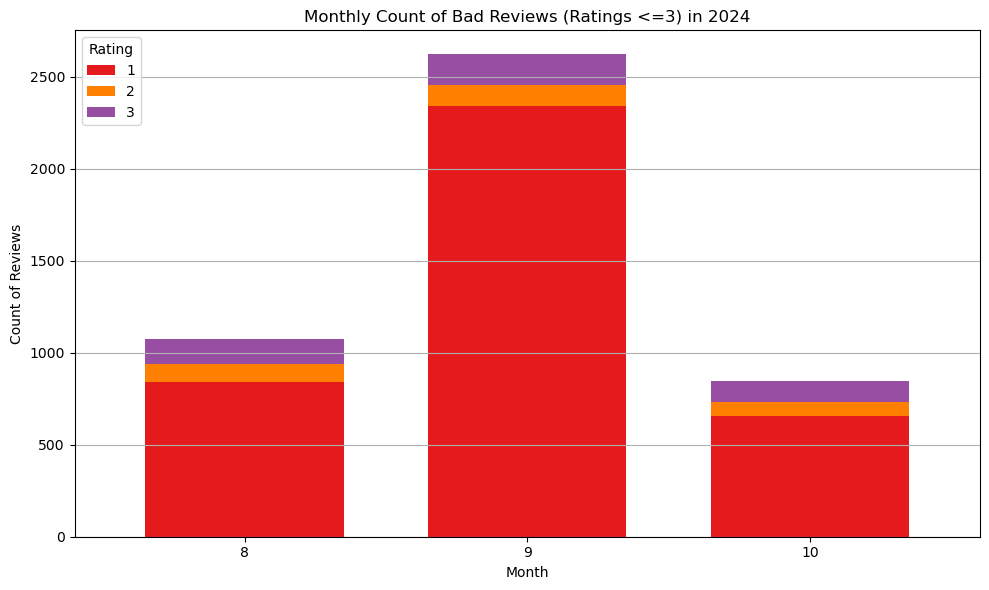

In [25]:
# Filter for bad reviews with rating 3 or lower
df_1_to_3_star = df_2024[(df_2024['rating'] <= 3) & (df_2024['month'] >= 8)]

# Count the number of reviews per month and rating for the stacked bar chart
rating_pivot = pd.crosstab(df_1_to_3_star['month'], df_1_to_3_star['rating'])

# Count the number of reviews per month for the line chart
review_counts = df_1_to_3_star['month'].value_counts().sort_index()
review_counts.index = review_counts.index.astype(str)

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
colors = ['#e41a1c', '#ff7f00', '#984ea3']  # Colors for ratings 1, 2, and 3
rating_pivot.plot(kind='bar', stacked=True, color=colors, ax=ax1, width=0.7)

# # Plot the line chart on the same axis
# ax1.plot(review_counts.index, review_counts.values, color='blue', marker='o', linestyle='-', label='Total Bad Reviews (Line)')

# Set labels and title
ax1.set_title('Monthly Count of Bad Reviews (Ratings <=3) in 2024')
ax1.set_xlabel('Month')
ax1.set_ylabel('Count of Reviews')

# Rotate the x-axis labels
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Legends
ax1.legend(title='Rating', loc='upper left')

# Adjust layout and add gridlines
plt.tight_layout()
plt.grid(axis='y')

# Show the plot
plt.show()


# Preprocessing for word cloud

In [40]:
df_2024.isna().sum()

review       0
date         0
rating       0
userName     0
thumbsUp     0
year         0
neg          0
neu          0
pos          0
compound     0
sentiment    0
count        0
month        0
dtype: int64

### Since some are not in english, we drop the reviews

In [11]:
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53752 entries, 0 to 53759
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   review    53752 non-null  object        
 1   date      53752 non-null  datetime64[ns]
 2   rating    53752 non-null  int64         
 3   userName  53752 non-null  object        
 4   thumbsUp  53752 non-null  int64         
 5   year      53752 non-null  int32         
 6   neg       53752 non-null  float64       
 7   neu       53752 non-null  float64       
 8   pos       53752 non-null  float64       
 9   compound  53752 non-null  float64       
 10  month     53752 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(2), int64(2), object(2)
memory usage: 4.5+ MB


In [12]:
from langdetect import detect, DetectorFactory

# Ensure consistent results from langdetect
DetectorFactory.seed = 0

# Function to detect language
def is_english(review):
    try:
        if len(review.split()) <= 3:
            return True
        return detect(review) == 'en'
    except:
        return False  # Return False if detection fails

# Apply the function to filter the DataFrame
df_2024['is_english'] = df_2024['review'].apply(is_english)

# Keep only English reviews
df_2024 = df_2024[df_2024['is_english'] == True].copy()

# Drop the temporary language detection column
df_2024 = df_2024.drop(columns=['is_english'])


In [14]:
df_2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45689 entries, 0 to 53759
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   review    45689 non-null  object        
 1   date      45689 non-null  datetime64[ns]
 2   rating    45689 non-null  int64         
 3   userName  45689 non-null  object        
 4   thumbsUp  45689 non-null  int64         
 5   year      45689 non-null  int32         
 6   neg       45689 non-null  float64       
 7   neu       45689 non-null  float64       
 8   pos       45689 non-null  float64       
 9   compound  45689 non-null  float64       
 10  month     45689 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(2), int64(2), object(2)
memory usage: 3.8+ MB


In [16]:
df_2024.to_excel('google_play_store_2024_dropped_non_english.xlsx',index=False)

## Coverting to small letters and removing punctuations

In [26]:
df_2024.iloc[45].review

"I'm a reseller and when the time that i ordered in this shop the item i got is wrong size and not even fit to wear , i am really dissapointed because i spend a big money and the seller isn't replying to give me a refund , it's waste full money, i already message lazada but still no respond , don't install this app , there are so many scammer seller , i'm really mad and dissapointed. Report this app to remove this in playstore"

In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

def cleanPunc(sentence): 
    # Only clean specific punctuation marks, but keep emojis and other unicode characters
    cleaned = re.sub(r'[?|!|\'|"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n", " ")
    return cleaned

df_2024['review'] = df_2024['review'].str.lower()
df_2024['review'] = df_2024['review'].apply(cleanPunc)
df_2024.iloc[45].review

'im a reseller and when the time that i ordered in this shop the item i got is wrong size and not even fit to wear   i am really dissapointed because i spend a big money and the seller isnt replying to give me a refund   its waste full money  i already message lazada but still no respond   dont install this app   there are so many scammer seller   im really mad and dissapointed  report this app to remove this in playstore'

## Remove stopwords

In [28]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within','lazada','app','1','2','3','4','5','6','7','8','9','10','shopee','even'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

df_2024['review'] = df_2024['review'].apply(removeStopWords)
df_2024.iloc[45].review

'im  reseller    time   ordered   shop  item  got  wrong size    fit  wear     really dissapointed   spend  big money   seller isnt replying  give   refund    waste full money   already message   still  respond   dont install        many scammer seller   im really mad  dissapointed  report    remove   playstore'

## Spacy Lemmatizer

In [29]:
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define a function to remove stopwords and lemmatize using spaCy
def spacy_lemmatizer(sentence):
    # Process the sentence with spaCy
    doc = nlp(sentence)
    
    # Lemmatize and remove stopwords
    lemmatized_sentence = " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space and token.lemma_.strip()])
    
    return lemmatized_sentence.strip()

# Apply the function to the 'review' column
df_2024['review'] = df_2024['review'].apply(spacy_lemmatizer)

'nice'

In [30]:
# Check the result for the 5th review
df_2024.iloc[45].review

'I m reseller time order shop item get wrong size fit wear really dissapointe spend big money seller be not reply give refund waste full money already message still respond do not install many scammer seller I m really mad dissapointe report remove playstore'

# Creating word cloud

## Analysis on review with rating 1

In [31]:
rating_1 = df_2024[df_2024['rating'] == 1]
rating_1

,review,date,rating,userName,thumbsUp,year,neg,neu,pos,compound,month
40,u r ad r irritating everywhere show withouttou...,2024-10-24 16:41:11,1,Jk Sam,0,2024,0.155,0.728,0.117,-0.1531,10
41,product way expensive 💯,2024-10-24 16:39:53,1,Walkingonair,0,2024,0.000,1.000,0.000,0.0000,10
44,cash money wallet take second already receive ...,2024-10-24 16:15:08,1,catherine pacoma,0,2024,0.049,0.951,0.000,-0.3612,10
48,can not chat real human customer service call ...,2024-10-24 15:35:59,1,Cedy,0,2024,0.000,1.000,0.000,0.0000,10
51,I m reseller time order shop item get wrong si...,2024-10-24 15:27:51,1,Love Cunanan,0,2024,0.161,0.839,0.000,-0.9010,10
...,...,...,...,...,...,...,...,...,...,...,...
53725,always pop another game site annoying,2024-01-01 09:17:10,1,Strikers Estayo,0,2024,0.241,0.759,0.000,-0.5410,1
53749,bad return refund policy bad customer care,2024-01-01 02:19:31,1,Anwar Sha,0,2024,0.483,0.306,0.212,-0.6629,1
53751,whenever try order tell cv02 please fix cv02 l...,2024-01-01 01:56:38,1,TECHNOLOGY ZONE,285,2024,0.105,0.667,0.229,0.3818,1
53756,excellent,2024-01-01 01:09:23,1,Bobby Siga,0,2024,0.000,0.000,1.000,0.5719,1


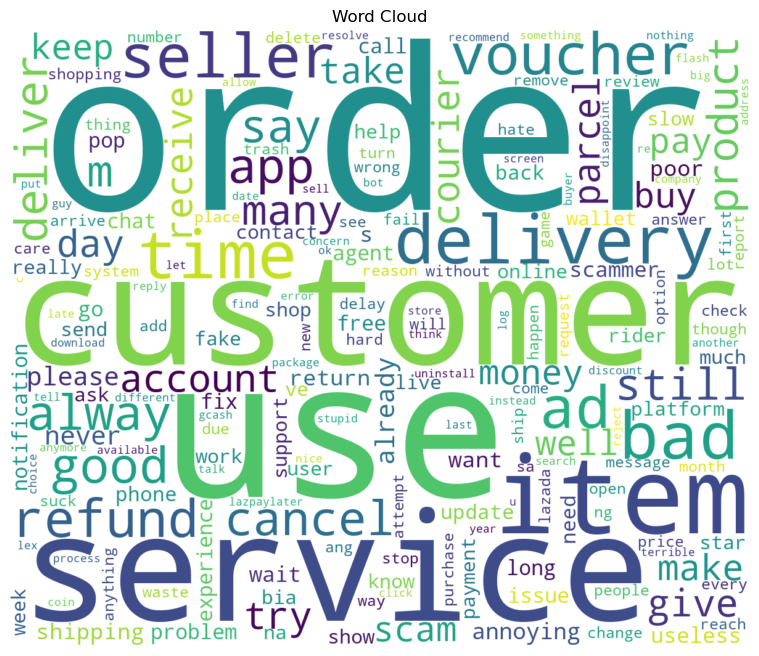

In [33]:
from wordcloud import WordCloud

# Concatenate all descriptions into a single string
text_cat = ' '.join(rating_1['review'].values)

# Generate the word cloud
wordcloud = WordCloud(max_font_size=None, background_color='white',collocations=False,
                      width=1200, height=1000).generate(text_cat)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis("off")
plt.show()

In [34]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Tokenize the text and count occurrences of each word
word_counts = Counter(word_tokenize(' '.join(rating_1['review'])))

# Print the word counts
print(word_counts)

Counter({'not': 2369, 'order': 1308, 'do': 1143, 'use': 914, 'customer': 913, 'can': 900, 'service': 876, 'item': 801, 'delivery': 788, 'time': 772, 'bad': 748, 'get': 653, 'seller': 647, 'ad': 602, 'voucher': 594, 'I': 588, 'refund': 558, 'good': 502, '👎': 494, 'app': 491, 'always': 488, 'cancel': 468, 'say': 436, 'deliver': 424, 'still': 404, 'm': 398, 'product': 384, 'many': 374, 'like': 363, 'account': 363, 'try': 358, 'give': 354, 'day': 347, 'courier': 346, 'receive': 340, '😡': 333, 'parcel': 330, 'take': 322, 'make': 322, 'money': 298, 'buy': 293, 'well': 290, 'keep': 289, 'pay': 288, 'please': 287, 'scam': 287, 'already': 284, 'never': 283, 'annoying': 283, 'return': 273, 'shipping': 271, 'poor': 265, 'want': 263, 's': 260, 'scammer': 248, 'go': 247, 'wait': 246, 'useless': 245, 'notification': 232, 'agent': 230, 'fix': 228, 'free': 227, 'issue': 223, 'call': 221, 'problem': 220, 'chat': 219, 'experience': 219, 'long': 219, 'pop': 217, 'phone': 210, 'need': 210, 'update': 210, 

In [35]:
# Access the first 10 words and their counts
first_10_words = word_counts.most_common(10)

# Print the first 20 words and their counts
print(first_10_words)

[('not', 2369), ('order', 1308), ('do', 1143), ('use', 914), ('customer', 913), ('can', 900), ('service', 876), ('item', 801), ('delivery', 788), ('time', 772)]


In [36]:
# Count the total number of words present
total_words = rating_1.shape[0]

# Create a DataFrame from the subset_words list
df_1_star = pd.DataFrame(first_10_words, columns=['word', 'count'])

# get the percentage of top 10 words across all 1 star review
df_1_star['percentage(%)'] = round(df_1_star['count'] * 100 / total_words,2)
df_1_star

,word,count,percentage(%)
0,not,2369,34.41
1,order,1308,19.00
2,do,1143,16.60
3,use,914,13.28
4,customer,913,13.26
5,can,900,13.07
6,service,876,12.72
7,item,801,11.63
8,delivery,788,11.45
9,time,772,11.21


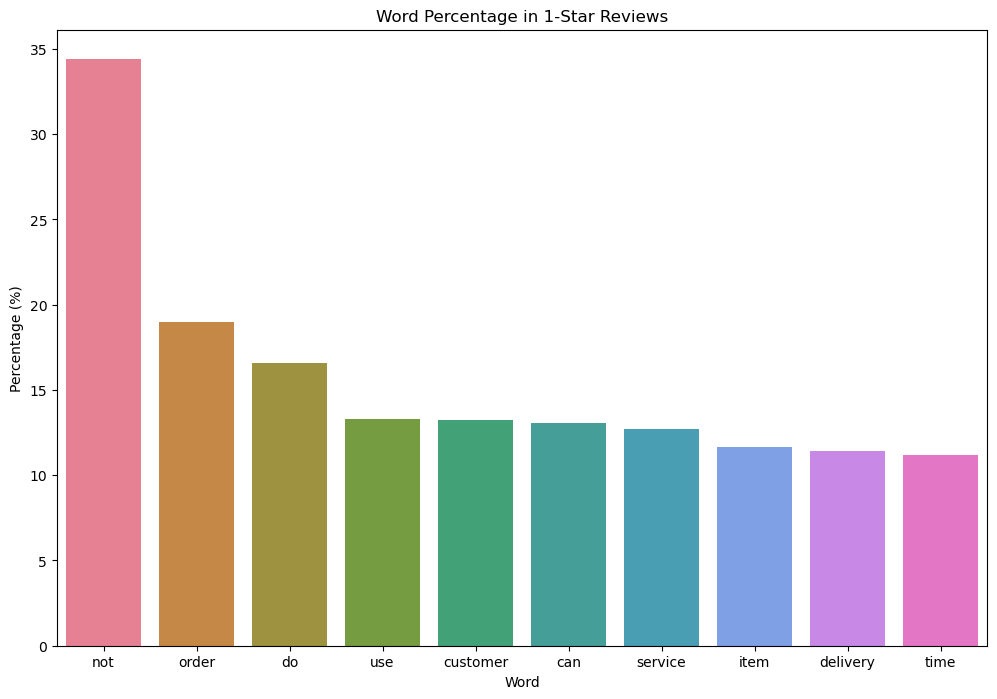

In [39]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Use the `palette` argument to assign different colors to each bar
sns.barplot(data=df_1_star, x='word', y='percentage(%)', palette="husl")  # 'husl' generates unique colors

# Set plot labels and title
plt.xlabel('Word')
plt.ylabel('Percentage (%)')
plt.title('Word Percentage in 1-Star Reviews')

# Display the plot
plt.show()

## Analysis on review with rating 2

In [40]:
rating_2 = df_2024[df_2024['rating'] == 2]
rating_2

,review,date,rating,userName,thumbsUp,year,neg,neu,pos,compound,month
131,really love issue item save do not appear card...,2024-10-24 07:18:51,2,Triple Via,1,2024,0.000,0.728,0.272,0.8656,10
149,light blue green,2024-10-24 01:34:52,2,Benigno Baylon,0,2024,0.000,1.000,0.000,0.0000,10
157,tap like actual like item default instead irri...,2024-10-24 00:16:50,2,Lo,0,2024,0.133,0.619,0.248,0.3818,10
169,thank,2024-10-23 22:42:43,2,Md Jfbk,0,2024,0.000,0.238,0.762,0.4927,10
326,nice,2024-10-23 06:59:41,2,Peter Garofil,0,2024,0.000,0.000,1.000,0.4215,10
...,...,...,...,...,...,...,...,...,...,...,...
53352,j express delivery always fail contact detail ...,2024-01-03 10:13:55,2,Glenn Ariño,6,2024,0.182,0.818,0.000,-0.8608,1
53427,good shopping thing there s lot scammer,2024-01-02 22:43:54,2,astra Nyx,0,2024,0.000,0.860,0.140,0.2382,1
53552,I ve cancel order confirm later delivery drive...,2024-01-02 10:36:59,2,Serein Sinclaire,0,2024,0.117,0.827,0.056,-0.3716,1
53594,legit ba,2024-01-02 05:09:29,2,Mansawi Ampaso,0,2024,0.000,1.000,0.000,0.0000,1


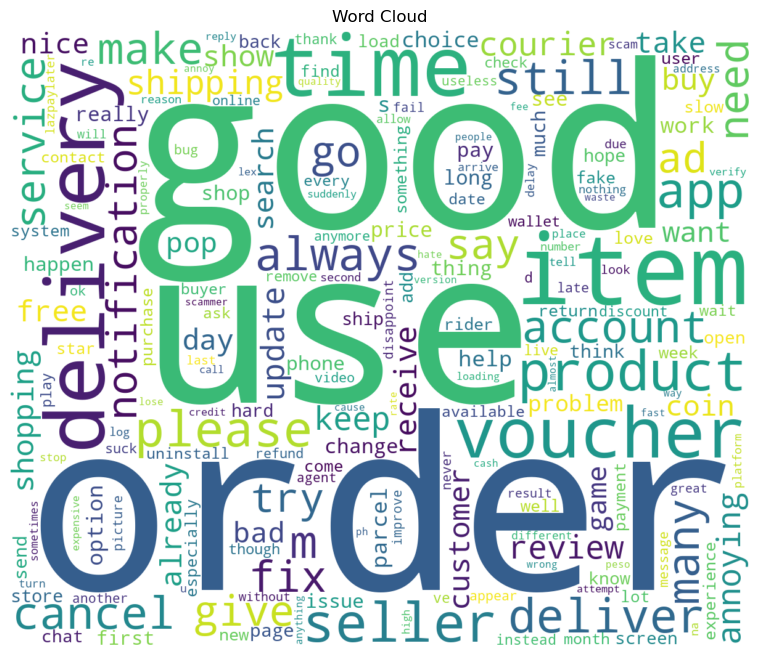

In [41]:
from wordcloud import WordCloud

# Concatenate all descriptions into a single string
text_cat = ' '.join(rating_2['review'].values)

# Generate the word cloud
wordcloud = WordCloud(max_font_size=None, background_color='white',collocations=False,
                      width=1200, height=1000).generate(text_cat)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis("off")
plt.show()

In [42]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Tokenize the text and count occurrences of each word
word_counts = Counter(word_tokenize(' '.join(rating_2['review'])))

# Print the word counts
print(word_counts)

Counter({'not': 318, 'order': 155, 'good': 139, 'can': 133, 'do': 131, 'use': 129, 'item': 127, 'time': 92, 'like': 87, 'delivery': 87, 'voucher': 86, 'product': 78, 'seller': 76, 'I': 74, 'get': 72, 'please': 63, 'app': 63, 'deliver': 56, 'always': 55, 'still': 55, 'm': 54, 'cancel': 52, 'many': 51, 'account': 51, 'make': 50, 'fix': 48, 'give': 47, 'need': 46, 'go': 46, 'ad': 45, 'notification': 45, 'service': 45, 'say': 45, 'try': 43, 'shipping': 43, 'courier': 41, 'keep': 40, 'review': 40, 'annoying': 40, 'update': 39, 'receive': 38, 'buy': 37, 'shopping': 37, 'already': 36, 'show': 36, 'customer': 36, 'free': 36, 'take': 35, 'day': 35, 'want': 35, 'search': 35, 'nice': 34, 'bad': 34, 'game': 33, 'coin': 33, 'problem': 33, 'option': 32, 'work': 32, 'parcel': 32, 'help': 32, 'choice': 31, 's': 31, 'pop': 31, 'it': 31, 'price': 30, 'really': 28, 'long': 28, 'change': 28, 'see': 28, 'shop': 28, 'pay': 28, 'thing': 28, 'issue': 27, 'phone': 27, 'happen': 27, 'much': 26, 'first': 26, 'th

In [43]:
# Access the first 10 words and their counts
first_10_words = word_counts.most_common(10)

# Print the first 20 words and their counts
print(first_10_words)

[('not', 318), ('order', 155), ('good', 139), ('can', 133), ('do', 131), ('use', 129), ('item', 127), ('time', 92), ('like', 87), ('delivery', 87)]


In [44]:
# Count the total number of words present
total_words = rating_2.shape[0]

# Create a DataFrame from the subset_words list
df_2_star = pd.DataFrame(first_10_words, columns=['word', 'count'])

# get the percentage of top 10 words across all 1 star review
df_2_star['percentage(%)'] = round(df_2_star['count'] * 100 / total_words,2)
df_2_star

,word,count,percentage(%)
0,not,318,37.28
1,order,155,18.17
2,good,139,16.30
3,can,133,15.59
4,do,131,15.36
5,use,129,15.12
6,item,127,14.89
7,time,92,10.79
8,like,87,10.20
9,delivery,87,10.20


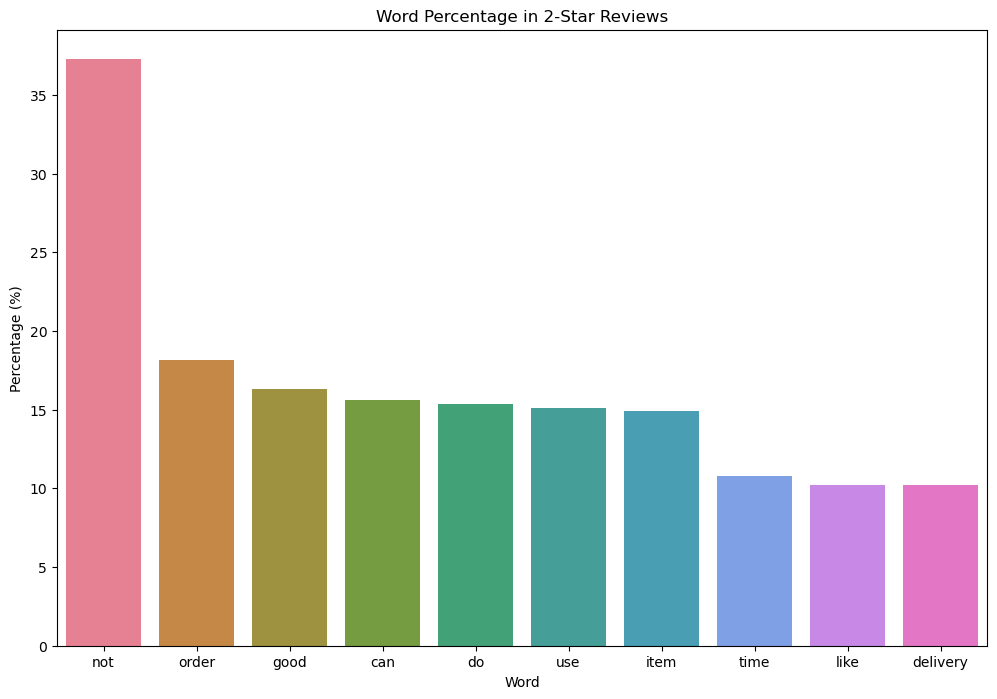

In [45]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Use the `palette` argument to assign different colors to each bar
sns.barplot(data=df_2_star, x='word', y='percentage(%)', palette="husl")  # 'husl' generates unique colors

# Set plot labels and title
plt.xlabel('Word')
plt.ylabel('Percentage (%)')
plt.title('Word Percentage in 2-Star Reviews')


# Display the plot
plt.show()

## Analysis on review with rating 3

In [46]:
rating_3 = df_2024[df_2024['rating'] == 3]
rating_3

,review,date,rating,userName,thumbsUp,year,neg,neu,pos,compound,month
6,reliable online shop offer discount favorite s...,2024-10-24 19:14:10,3,ROSÉ PARK,0,2024,0.000,0.953,0.047,0.4588,10
21,should not accessible new zealand open show so...,2024-10-24 18:02:02,3,James Topia,0,2024,0.130,0.870,0.000,-0.5777,10
34,new msg system pure chaotic useless msg alread...,2024-10-24 17:14:51,3,Sean Sean,0,2024,0.370,0.630,0.000,-0.8313,10
112,ok,2024-10-24 10:03:11,3,Cynthia Libres,0,2024,0.000,0.000,1.000,0.2960,10
153,good,2024-10-24 00:54:55,3,Md Sagor Hassan,0,2024,0.000,0.238,0.762,0.4927,10
...,...,...,...,...,...,...,...,...,...,...,...
53439,today morning order do not know problem,2024-01-02 21:55:50,3,thant win,0,2024,0.000,0.708,0.292,0.4380,1
53480,annoying ad,2024-01-02 18:29:39,3,Kiel Tayag,5,2024,0.730,0.270,0.000,-0.4019,1
53503,thank lazada,2024-01-02 16:24:20,3,Renz Subeldia,0,2024,0.000,0.286,0.714,0.3612,1
53647,ask cvc card opt pay via c d,2024-01-01 18:59:58,3,julio panaligan,0,2024,0.138,0.862,0.000,-0.1926,1


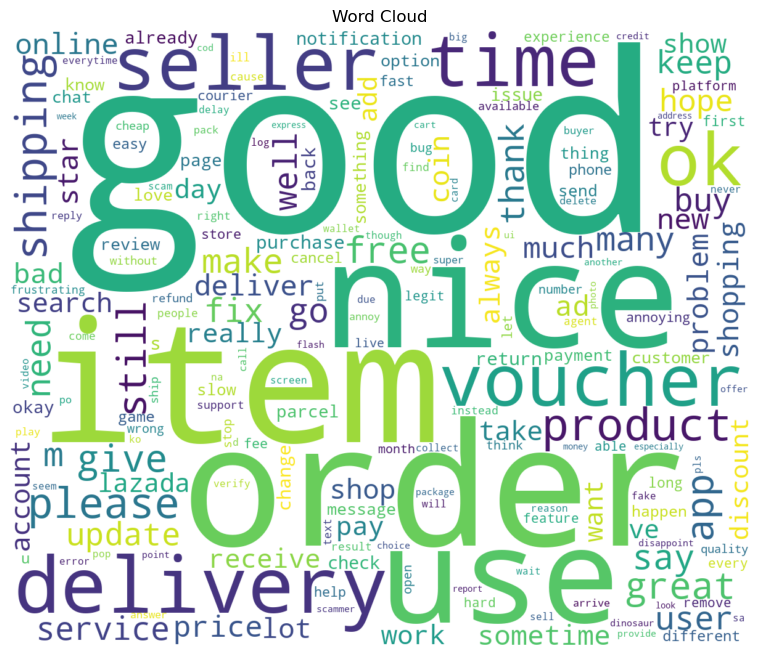

In [47]:
from wordcloud import WordCloud

# Concatenate all descriptions into a single string
text_cat = ' '.join(rating_3['review'].values)

# Generate the word cloud
wordcloud = WordCloud(max_font_size=None, background_color='white',collocations=False,
                      width=1200, height=1000).generate(text_cat)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis("off")
plt.show()

In [48]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Tokenize the text and count occurrences of each word
word_counts = Counter(word_tokenize(' '.join(rating_3['review'])))

# Print the word counts
print(word_counts)

Counter({'good': 338, 'not': 183, 'order': 125, 'item': 122, 'nice': 118, 'like': 99, 'use': 93, 'can': 83, 'do': 80, 'get': 78, 'delivery': 77, 'seller': 70, 'I': 67, 'voucher': 67, 'ok': 66, 'time': 66, 'product': 66, 'shipping': 61, 'please': 60, 'still': 52, 'app': 48, 'give': 47, 'great': 46, 'free': 45, '👍': 40, 'say': 39, 'go': 39, 'thank': 39, 'make': 39, 'm': 39, 'fix': 38, 'need': 38, 'many': 38, 'well': 36, 'user': 36, 'buy': 35, 'service': 35, 'update': 34, 'keep': 33, 'hope': 33, 'much': 31, 'price': 31, 'online': 30, 'deliver': 30, 'star': 30, 'it': 30, 'shopping': 29, 'new': 29, 'ad': 29, 'problem': 29, 'coin': 29, 'shop': 28, 'bad': 28, 'lot': 28, 'always': 28, 'take': 27, 'sometimes': 27, 'search': 27, 'account': 27, 'day': 26, 'show': 26, 'really': 26, 'work': 26, 'pay': 26, 'receive': 26, 've': 25, 'want': 25, 'add': 25, 'try': 25, 'discount': 24, 'purchase': 24, 'return': 24, 'back': 24, 'see': 24, 's': 24, 'change': 24, 'check': 23, 'notification': 23, 'issue': 23,

In [51]:
# Access the first 10 words and their counts
first_20_words = word_counts.most_common(20)

# Print the first 20 words and their counts
print(first_20_words)

[('good', 338), ('not', 183), ('order', 125), ('item', 122), ('nice', 118), ('like', 99), ('use', 93), ('can', 83), ('do', 80), ('get', 78), ('delivery', 77), ('seller', 70), ('I', 67), ('voucher', 67), ('ok', 66), ('time', 66), ('product', 66), ('shipping', 61), ('please', 60), ('still', 52)]


In [52]:
selected_indices = [0, 2, 3, 4, 5, 6, 7, 9, 10, 11]

# Use tuple comprehension to extract the values at those indices
first_10_words = tuple(first_20_words[i] for i in selected_indices)

first_10_words

(('good', 338),
 ('order', 125),
 ('item', 122),
 ('nice', 118),
 ('like', 99),
 ('use', 93),
 ('can', 83),
 ('get', 78),
 ('delivery', 77),
 ('seller', 70))

In [53]:
# Count the total number of words present
total_words = rating_3.shape[0]

# Create a DataFrame from the subset_words list
df_3_star = pd.DataFrame(first_10_words, columns=['word', 'count'])

# get the percentage of top 10 words across all 1 star review
df_3_star['percentage(%)'] = round(df_3_star['count'] * 100 / total_words,2)
df_3_star

,word,count,percentage(%)
0,good,338,26.91
1,order,125,9.95
2,item,122,9.71
3,nice,118,9.39
4,like,99,7.88
5,use,93,7.40
6,can,83,6.61
7,get,78,6.21
8,delivery,77,6.13
9,seller,70,5.57


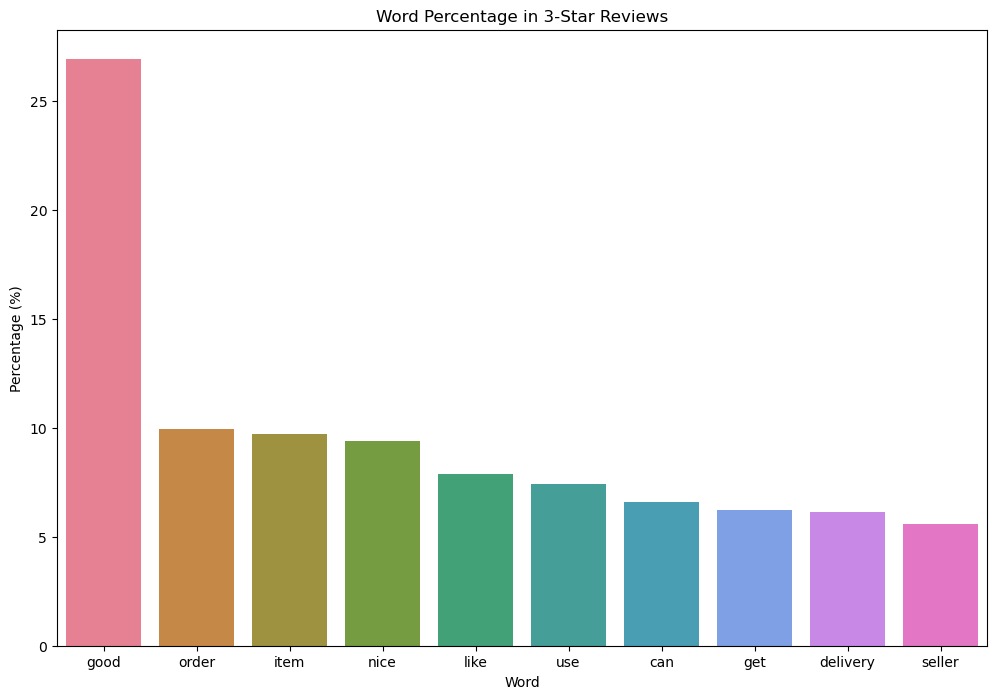

In [54]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Use the `palette` argument to assign different colors to each bar
sns.barplot(data=df_3_star, x='word', y='percentage(%)', palette="husl")  # 'husl' generates unique colors

# Set plot labels and title
plt.xlabel('Word')
plt.ylabel('Percentage (%)')
plt.title('Word Percentage in 3-Star Reviews')

# Display the plot
plt.show()

## Analysis of review with rating 4

In [59]:
rating_4 = df_2024[df_2024['rating'] == 4]
rating_4

,review,date,rating,userName,thumbsUp,year,neg,neu,pos,compound,month
8,good product,2024-10-24 19:06:07,4,Leandro Aliposa,0,2024,0.000,0.256,0.744,0.4404,10
57,I m satisfied easy use,2024-10-24 14:39:33,4,Kirshan Murugan,0,2024,0.000,0.513,0.487,0.6908,10
73,version compatible gbox google play store able...,2024-10-24 13:33:27,4,GOH TOH YEE,0,2024,0.000,0.844,0.156,0.3400,10
90,good,2024-10-24 11:46:52,4,JOEL ROMANGGAYA,0,2024,0.000,0.000,1.000,0.4404,10
133,good,2024-10-24 07:00:37,4,Kaye Anne Cordero,0,2024,0.000,0.000,1.000,0.4404,10
...,...,...,...,...,...,...,...,...,...,...,...
53691,good fast,2024-01-01 13:22:50,4,Dominic Mendez,0,2024,0.000,0.408,0.592,0.4404,1
53717,issue agent sometimes willing help,2024-01-01 10:20:10,4,Jan Singcol,0,2024,0.201,0.799,0.000,-0.3089,1
53729,good,2024-01-01 08:16:28,4,ako si digong,0,2024,0.000,0.000,1.000,0.4404,1
53742,tgdggdy3pila pud ug way parachutepila pud ug w...,2024-01-01 04:06:03,4,Mark,0,2024,0.066,0.652,0.282,0.9703,1


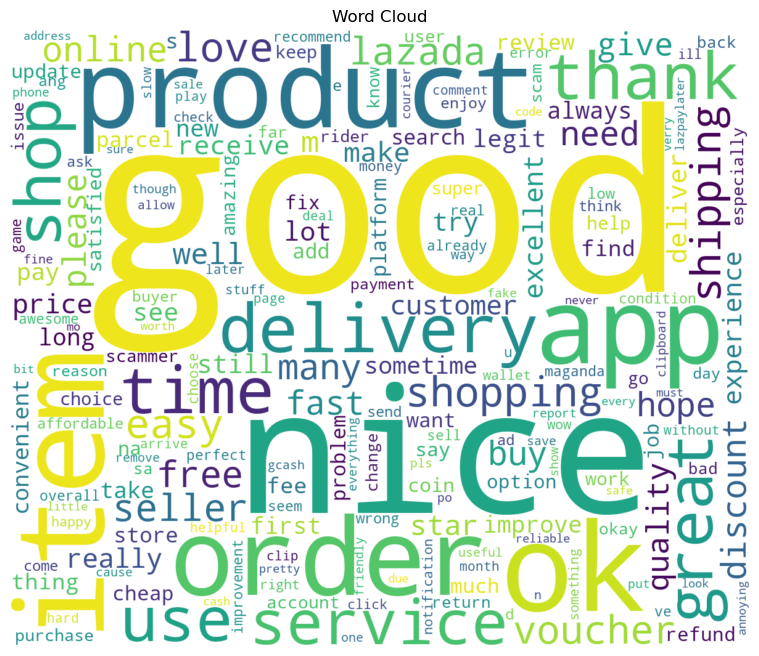

In [60]:
from wordcloud import WordCloud

# Concatenate all descriptions into a single string
text_cat = ' '.join(rating_4['review'].values)

# Generate the word cloud
wordcloud = WordCloud(max_font_size=None, background_color='white',collocations=False,
                      width=1200, height=1000).generate(text_cat)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis("off")
plt.show()

In [61]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Tokenize the text and count occurrences of each word
word_counts = Counter(word_tokenize(' '.join(rating_4['review'])))

# Print the word counts
print(word_counts)

Counter({'good': 844, 'nice': 324, '👍': 145, 'ok': 133, 'item': 131, 'not': 122, 'product': 105, 'order': 100, 'app': 98, 'delivery': 83, 'like': 80, 'time': 77, 'great': 76, 'thank': 75, 'shop': 73, 'use': 72, 'service': 71, 'shopping': 67, 'shipping': 67, 'easy': 64, 'love': 64, 'I': 63, 'do': 60, 'voucher': 59, 'get': 58, '️': 57, 'lazada': 57, 'seller': 56, 'free': 53, 'many': 50, 'online': 49, 'discount': 48, 'buy': 46, 'hope': 46, 'need': 46, 'fast': 46, '😊': 45, 'please': 43, 'can': 43, 'give': 42, 'quality': 41, 'm': 40, 'well': 39, 'star': 37, 'make': 34, 'excellent': 33, 'customer': 33, 'price': 33, 'really': 33, '🥰': 32, 'receive': 32, 'it': 32, 'deliver': 32, 'lot': 32, 'try': 31, 'experience': 31, '❤': 30, 'still': 30, 'see': 30, 'legit': 29, 'pay': 28, 'always': 27, 'you': 27, 'first': 27, 'long': 27, 'new': 26, 'take': 26, 'improve': 26, 'convenient': 26, 'sometimes': 26, 'thing': 25, 'find': 25, 'fee': 25, 'store': 24, 's': 24, 'review': 24, 'parcel': 24, 'search': 23, 

In [62]:
# Access the first 10 words and their counts
first_10_words = word_counts.most_common(10)

# Print the first 20 words and their counts
print(first_10_words)

[('good', 844), ('nice', 324), ('👍', 145), ('ok', 133), ('item', 131), ('not', 122), ('product', 105), ('order', 100), ('app', 98), ('delivery', 83)]


In [63]:
# Count the total number of words present
total_words = rating_4.shape[0]

# Create a DataFrame from the subset_words list
df_4_star = pd.DataFrame(first_10_words, columns=['word', 'count'])

# get the percentage of top 10 words across all 1 star review
df_4_star['percentage(%)'] = round(df_4_star['count'] * 100 / total_words,2)
df_4_star

,word,count,percentage(%)
0,good,844,34.59
1,nice,324,13.28
2,👍,145,5.94
3,ok,133,5.45
4,item,131,5.37
5,not,122,5.00
6,product,105,4.30
7,order,100,4.10
8,app,98,4.02
9,delivery,83,3.40


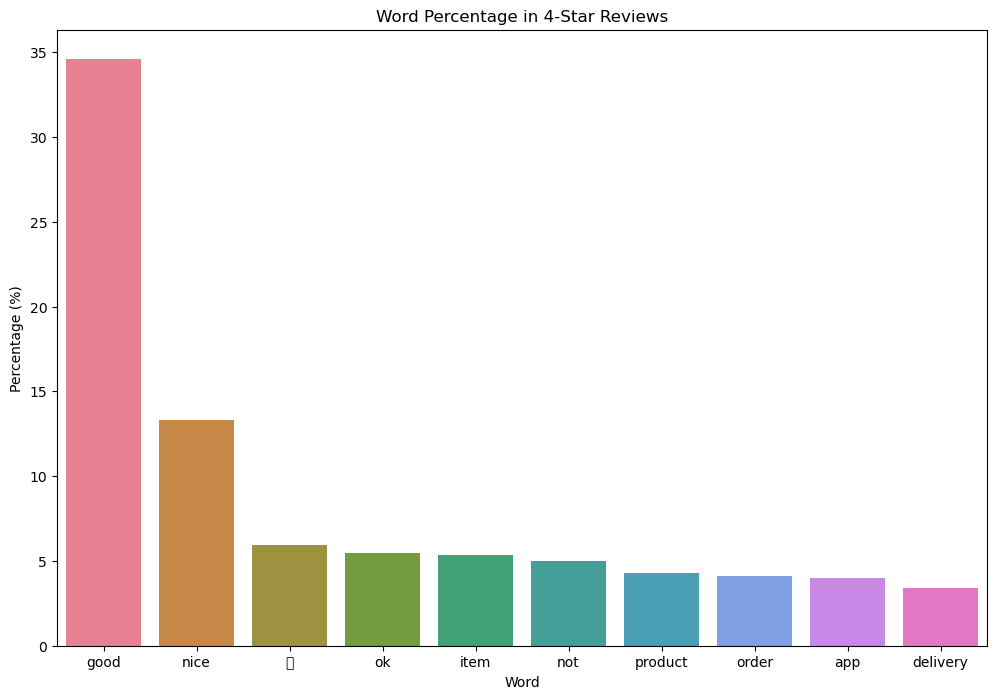

In [64]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Use the `palette` argument to assign different colors to each bar
sns.barplot(data=df_4_star, x='word', y='percentage(%)', palette="husl")  # 'husl' generates unique colors

# Set plot labels and title
plt.xlabel('Word')
plt.ylabel('Percentage (%)')
plt.title('Word Percentage in 4-Star Reviews')

# Display the plot
plt.show()

## Analysis on review with ratig 5

In [65]:
rating_5 = df_2024[df_2024['rating'] == 5]
rating_5

,review,date,rating,userName,thumbsUp,year,neg,neu,pos,compound,month
0,good app lazada,2024-10-24 20:32:48,5,Amir Hossain,0,2024,0.0,0.408,0.592,0.4404,10
1,michael lumacadchona26,2024-10-24 20:04:06,5,Michael Lumacad,0,2024,0.0,1.000,0.000,0.0000,10
2,I m satisfied,2024-10-24 19:53:13,5,Ernilo Soria,0,2024,0.0,0.263,0.737,0.4215,10
3,nice,2024-10-24 19:41:21,5,rosemarie delacruz,0,2024,0.0,0.000,1.000,0.4215,10
4,great,2024-10-24 19:22:20,5,"Alcantara, Henry A.",0,2024,0.0,0.000,1.000,0.6249,10
...,...,...,...,...,...,...,...,...,...,...,...
53753,great app,2024-01-01 01:17:54,5,Jerson Escabusa,0,2024,0.0,0.185,0.815,0.6588,1
53754,nice,2024-01-01 01:17:50,5,Cesar Landicho,0,2024,0.0,0.000,1.000,0.4215,1
53755,wow,2024-01-01 01:11:57,5,Edwin Canonigo,0,2024,0.0,0.000,1.000,0.5859,1
53758,nice app,2024-01-01 00:08:56,5,Gideon Raquepo,0,2024,0.0,0.263,0.737,0.4215,1


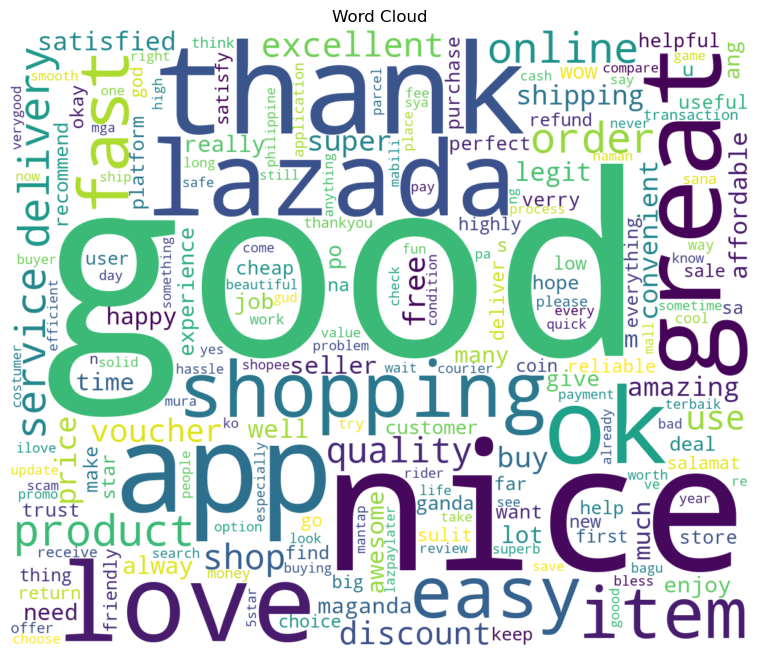

In [66]:
from wordcloud import WordCloud

# Concatenate all descriptions into a single string
text_cat = ' '.join(rating_5['review'].values)

# Generate the word cloud
wordcloud = WordCloud(max_font_size=None, background_color='white',collocations=False,
                      width=1200, height=1000).generate(text_cat)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud')
plt.axis("off")
plt.show()

In [67]:
from collections import Counter
from nltk.tokenize import word_tokenize

# Tokenize the text and count occurrences of each word
word_counts = Counter(word_tokenize(' '.join(rating_5['review'])))

# Print the word counts
print(word_counts)

Counter({'good': 11770, 'nice': 4682, '👍': 3133, '️': 2077, 'thank': 1930, 'app': 1879, '❤': 1729, 'great': 1572, 'love': 1451, 'ok': 1341, 'lazada': 1312, 'shopping': 1216, '🥰': 1187, 'easy': 1052, 'item': 1009, '😍': 988, 'fast': 953, 'product': 906, 'delivery': 872, 'online': 838, 'order': 832, 'service': 814, 'quality': 774, 'shop': 741, 'excellent': 717, '😊': 705, 'use': 683, 'discount': 596, 'voucher': 590, 'like': 550, 'free': 543, 'price': 520, 'it': 514, 'super': 504, 'buy': 488, 'I': 484, 'you': 474, '💯': 459, 'shipping': 449, 'amazing': 435, 'convenient': 428, 'legit': 416, 'satisfied': 414, 'well': 386, 'much': 376, 'seller': 376, 'time': 366, '♥': 360, 'awesome': 359, 'affordable': 355, 'always': 336, 'happy': 327, 'm': 326, 'lot': 323, 'many': 306, 'really': 299, 'need': 297, 'get': 295, 'give': 283, 'maganda': 282, 'job': 275, 'not': 274, 'enjoy': 274, 'experience': 257, '👌': 257, 'ang': 253, '⭐': 242, 'po': 241, 'wow': 238, '😘': 231, '👏': 216, 'hope': 210, 'u': 209, 'pla

In [69]:
# Access the first 10 words and their counts
first_20_words = word_counts.most_common(20)
# Print the first 20 words and their counts
print(first_20_words)

[('good', 11770), ('nice', 4682), ('👍', 3133), ('️', 2077), ('thank', 1930), ('app', 1879), ('❤', 1729), ('great', 1572), ('love', 1451), ('ok', 1341), ('lazada', 1312), ('shopping', 1216), ('🥰', 1187), ('easy', 1052), ('item', 1009), ('😍', 988), ('fast', 953), ('product', 906), ('delivery', 872), ('online', 838)]


In [70]:
selected_indices = [0, 1, 4, 5, 5, 11, 13, 14, 16, 17]

# Use tuple comprehension to extract the values at those indices
first_10_words = tuple(first_20_words[i] for i in selected_indices)

first_10_words

(('good', 11770),
 ('nice', 4682),
 ('thank', 1930),
 ('app', 1879),
 ('app', 1879),
 ('shopping', 1216),
 ('easy', 1052),
 ('item', 1009),
 ('fast', 953),
 ('product', 906))

In [72]:
# Count the total number of words present
total_words = rating_5.shape[0]

# Create a DataFrame from the subset_words list
df_5_star = pd.DataFrame(first_10_words, columns=['word', 'count'])

# get the percentage of top 10 words across all 1 star review
df_5_star['percentage(%)'] = round(df_5_star['count'] * 100 / total_words,2)
df_5_star

,word,count,percentage(%)
0,good,11770,34.36
1,nice,4682,13.67
2,thank,1930,5.63
3,app,1879,5.49
4,app,1879,5.49
5,shopping,1216,3.55
6,easy,1052,3.07
7,item,1009,2.95
8,fast,953,2.78
9,product,906,2.64


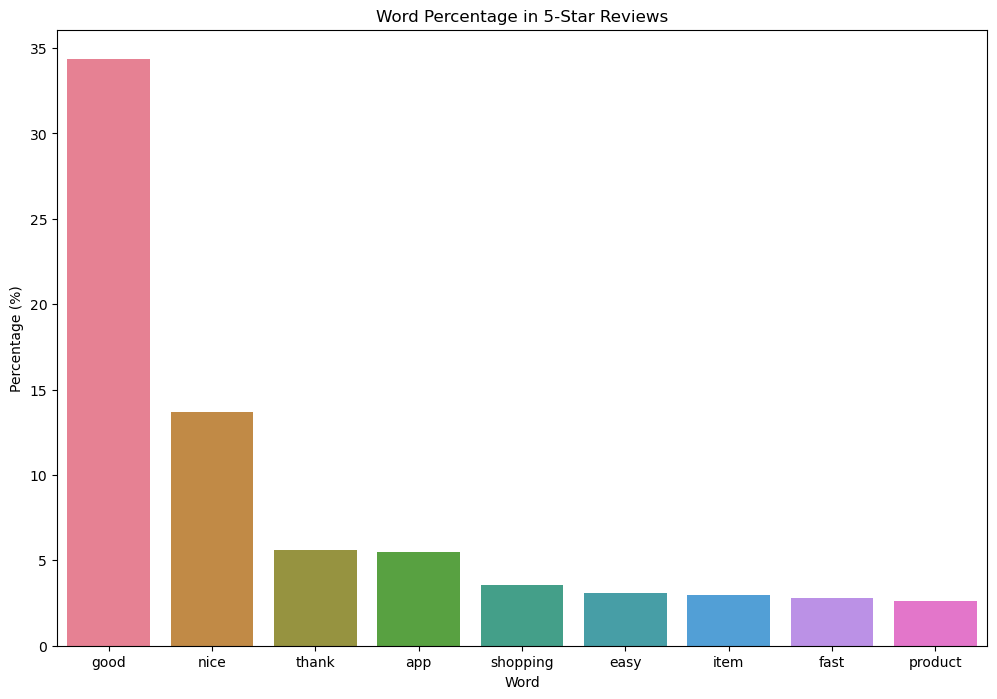

In [73]:
# Set the figure size
plt.figure(figsize=(12, 8))

# Use the `palette` argument to assign different colors to each bar
sns.barplot(data=df_5_star, x='word', y='percentage(%)', palette="husl")  # 'husl' generates unique colors

# Set plot labels and title
plt.xlabel('Word')
plt.ylabel('Percentage (%)')
plt.title('Word Percentage in 5-Star Reviews')

# Display the plot
plt.show()

# Topic Modeling for reviews with rating <= 3 for most recent 3 months

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from pprint import pprint

df = pd.read_excel("google_play_store_2024_dropped_non_english.xlsx")
df = df[(df['rating'] <= 3) & (df['date'] >= '2024-08')].reset_index()

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3493 entries, 0 to 3492
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   index     3493 non-null   int64         
 1   review    3493 non-null   object        
 2   date      3493 non-null   datetime64[ns]
 3   rating    3493 non-null   int64         
 4   userName  3493 non-null   object        
 5   thumbsUp  3493 non-null   int64         
 6   year      3493 non-null   int64         
 7   neg       3493 non-null   float64       
 8   neu       3493 non-null   float64       
 9   pos       3493 non-null   float64       
 10  compound  3493 non-null   float64       
 11  month     3493 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(2)
memory usage: 327.6+ KB


In [3]:
df.head(5)

,index,review,date,rating,userName,thumbsUp,year,neg,neu,pos,compound,month
0,6,"Lazada is a very reliable online shop, offerin...",2024-10-24 19:14:10,3,ROSÉ PARK,0,2024,0.000,0.953,0.047,0.4588,10
1,20,Lazada shouldn't be accessible in new Zealand ...,2024-10-24 18:02:02,3,James Topia,0,2024,0.130,0.870,0.000,-0.5777,10
2,28,"This new msg system is pure chaotic, useless m...",2024-10-24 17:14:51,3,Sean Sean,0,2024,0.370,0.630,0.000,-0.8313,10
3,34,Why u r ads r too irritating no everywhere? It...,2024-10-24 16:41:11,1,Jk Sam,0,2024,0.155,0.728,0.117,-0.1531,10
4,35,YOUR PRODUCTS ARE WAY MORE EXPENSIVE THAN SHOP...,2024-10-24 16:39:53,1,Walkingonair,0,2024,0.000,1.000,0.000,0.0000,10


In [4]:
# Gensim (Topic Modeling Pacakge)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within','lazada','app','1','2','3','4','5','6','7','8','9','10','shopee','even'])

In [5]:
df.review[5]

"when we cash in our money in you Lazada wallet it takes a second and you already received our money but when we cash out or withdraw our money it takes a week before we received our money back and sometimes the request is cancelled and we can't get our money back.."

In [6]:
# Convert to list
data = df.review.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[5])

when we cash in our money in you Lazada wallet it takes a second and you already received our money but when we cash out or withdraw our money it takes a week before we received our money back and sometimes the request is cancelled and we cant get our money back..


In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[5])

['when', 'we', 'cash', 'in', 'our', 'money', 'in', 'you', 'lazada', 'wallet', 'it', 'takes', 'second', 'and', 'you', 'already', 'received', 'our', 'money', 'but', 'when', 'we', 'cash', 'out', 'or', 'withdraw', 'our', 'money', 'it', 'takes', 'week', 'before', 'we', 'received', 'our', 'money', 'back', 'and', 'sometimes', 'the', 'request', 'is', 'cancelled', 'and', 'we', 'cant', 'get', 'our', 'money', 'back']


In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=50, threshold=20) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=20)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[5]]])

['when', 'we', 'cash', 'in', 'our_money', 'in', 'you', 'lazada_wallet', 'it', 'takes', 'second', 'and', 'you', 'already', 'received', 'our_money', 'but', 'when', 'we', 'cash', 'out', 'or', 'withdraw', 'our_money', 'it', 'takes', 'week', 'before', 'we', 'received', 'our_money', 'back', 'and', 'sometimes', 'the', 'request', 'is', 'cancelled', 'and', 'we', 'cant', 'get', 'our_money', 'back']


In [9]:
'''
The bigrams model is ready. Let’s define the functions to remove the stopwords, 
make bigrams and lemmatization and call them sequentially.
'''
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
'''
Let’s call the functions in order.
'''
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

'''
If it reports error "Can't find model 'en'. It doesn't seem to be a shortcut link, 
a Python package or a valid path to a data directory", you need to do following in command line:

> python -m spacy download en

It works only if you have administrator rights as the installation folder needs that. Otherwise
you will receive error "Download successful but linking failed. Creating a shortcut link for 'en' 
didn't work (maybe you don't have admin permissions?), but you can still load the model via its 
full package name: nlp = spacy.load('en_core_web_sm')". It may not work even you do as suggested.
In such case, you need to open Anadaconda's cmd prompt as an Administrator:

1. Right clik on the Anaconda Promt Icon
2. Go to "More" and click on "Open as Administrator"
3. Then type: python -m spacy download en
'''

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[5])

['cash', 'money', 'wallet', 'take', 'second', 'already', 'receive', 'money', 'cash', 'withdraw', 'money', 'take', 'week', 'receive', 'money', 'back', 'sometimes', 'request', 'cancel', 'get', 'money', 'back']


In [11]:
'''
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.
Let’s create them.
'''
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[5:6])

[[(28, 2), (37, 1), (60, 2), (61, 1), (62, 2), (63, 1), (64, 5), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1)]]


In [16]:
'''
We have everything required to train the LDA model.
In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics.
According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk.

update_every determines how often the model parameters should be updated and 
passes is the total number of training passes.
'''
'''
We have everything required to train the LDA model.
In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics.
According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk.

update_every determines how often the model parameters should be updated and 
passes is the total number of training passes.
'''
# Build LDA model
import gensim
from gensim.models.coherencemodel import CoherenceModel

# Define the function to train LDA models with different numbers of topics
def test_lda_models(corpus, id2word, data_lemmatized, topic_range, passes=15, random_state=100):
    results = []

    for num_topics in topic_range:
        # Train the LDA model
        lda_model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            random_state=random_state,
            update_every=1,
            passes=passes,
            alpha='auto',
            eta=0.01,
            per_word_topics=True
        )

        # Compute Perplexity
        perplexity = lda_model.log_perplexity(corpus)

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()

        # Append results
        results.append({
            'num_topics': num_topics,
            'perplexity': perplexity,
            'coherence_score': coherence_score
        })

        # Print the results for the current model
        print(f'Number of Topics: {num_topics}, Perplexity: {perplexity:.4f}, Coherence Score: {coherence_score:.4f}')

    return results

# Define the range of topics you want to test
topic_range = range(3, 16, 1)  # Example: Test from 5 to 20 topics, in steps of 2

# Run the function and collect results
results = test_lda_models(corpus=corpus, id2word=id2word, data_lemmatized=data_lemmatized, topic_range=topic_range)
results_df = pd.DataFrame(results)

Number of Topics: 3, Perplexity: -11.8943, Coherence Score: 0.6072
Number of Topics: 4, Perplexity: -11.9395, Coherence Score: 0.6312
Number of Topics: 5, Perplexity: -11.9500, Coherence Score: 0.6262
Number of Topics: 6, Perplexity: -11.9674, Coherence Score: 0.5954
Number of Topics: 7, Perplexity: -11.9575, Coherence Score: 0.5514
Number of Topics: 8, Perplexity: -11.9736, Coherence Score: 0.5773
Number of Topics: 9, Perplexity: -11.9742, Coherence Score: 0.5599
Number of Topics: 10, Perplexity: -11.9832, Coherence Score: 0.5702
Number of Topics: 11, Perplexity: -11.9863, Coherence Score: 0.5167
Number of Topics: 12, Perplexity: -12.0010, Coherence Score: 0.5756
Number of Topics: 13, Perplexity: -11.9776, Coherence Score: 0.5534
Number of Topics: 14, Perplexity: -12.0135, Coherence Score: 0.5485
Number of Topics: 15, Perplexity: -12.0112, Coherence Score: 0.5607


In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           passes=15,
                                           alpha='auto',
                                            eta=0.01,
                                           per_word_topics=True)

In [15]:
# Display the topics
topics = lda_model.show_topics(num_topics=5, num_words=10, formatted=False)

# Print the topics in a readable format
print("Topics found via LDA:\n")
for idx, topic in topics:
    print(f"Topic #{idx+1}:")
    print(" ".join([word for word, _ in topic]))
    print()

Topics found via LDA:

Topic #1:
scammer nice money pay voucher buy payment price product online

Topic #2:
time voucher get account order always delivery day m say

Topic #3:
good ad bias annoying pop notification app many show big

Topic #4:
bad delivery courier slow poor service well fake scam deliver

Topic #5:
order item refund seller return customer_service customer agent receive chat



### Topic #1: Scams and Payment Issues
Keywords: scammer, nice, money, pay, voucher, buy, payment, price, product, online

Explanation: This topic revolves around concerns regarding scams in online transactions. It indicates that customers are wary of fraudulent activities where scammers may use enticing offers (like vouchers) to lure individuals into making payments. This sentiment reflects a lack of trust in the platform or vendor regarding payment security and the integrity of the products being sold.
### Topic #2: Delivery and Order Issues
Keywords: time, voucher, get, account, order, always, delivery, day, m, say

Explanation: This topic highlights issues related to the timing and reliability of delivery. It suggests frustration over delays in receiving orders or issues with the order tracking process. The mention of "voucher" may imply that customers expect certain promotions or delivery guarantees that were not met, resulting in dissatisfaction with the service.
### Topic #3: Annoying Advertisements
Keywords: good, ad, bias, annoying, pop, notification, app, many, show, big

Explanation: This topic reflects customer frustrations with intrusive advertisements, particularly in apps. Terms like "annoying" and "pop" suggest that users are tired of excessive ads that disrupt their experience, potentially leading to negative perceptions of the app's usability. This concern often relates to the overall user experience and can impact customer retention.
### Topic #4: Poor Service and Delivery Experiences
Keywords: bad, delivery, courier, slow, poor, service, well, fake, scam, deliver

Explanation: This topic captures negative sentiments related to delivery services. Customers report slow or inadequate service from couriers, which leads to dissatisfaction. The terms "fake" and "scam" indicate a broader concern regarding the legitimacy of the delivery process or the quality of the service provided. This reflects poorly on the company’s reliability in fulfilling orders.
### Topic #5: Refund and Customer Service Issues
Keywords: order, item, refund, seller, return, customer_service, customer, agent, receive, chat

Explanation: This topic is centered around customer service interactions related to refunds and returns. Customers express frustrations with the process of returning items, receiving refunds, or communicating with customer service representatives. This indicates a need for improvement in the handling of customer inquiries and transaction issues, as unresolved problems in this area can lead to significant dissatisfaction.
### Summary
Overall, these topics suggest a range of concerns from consumers about online shopping experiences, highlighting the importance of trust, delivery reliability, user experience with advertisements, and effective customer service. Addressing these issues could help improve customer satisfaction and loyalty.

In [127]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.024*"scammer" + 0.020*"nice" + 0.019*"money" + 0.018*"pay" + '
  '0.017*"voucher" + 0.017*"buy" + 0.017*"payment" + 0.015*"price" + '
  '0.015*"product" + 0.013*"online"'),
 (1,
  '0.035*"time" + 0.027*"voucher" + 0.022*"get" + 0.019*"account" + '
  '0.018*"order" + 0.013*"always" + 0.013*"delivery" + 0.012*"day" + 0.011*"m" '
  '+ 0.011*"say"'),
 (2,
  '0.106*"good" + 0.069*"ad" + 0.043*"bias" + 0.027*"annoying" + 0.022*"pop" + '
  '0.020*"notification" + 0.017*"app" + 0.015*"many" + 0.015*"show" + '
  '0.014*"big"'),
 (3,
  '0.059*"bad" + 0.051*"delivery" + 0.021*"courier" + 0.020*"slow" + '
  '0.019*"poor" + 0.019*"service" + 0.019*"well" + 0.016*"fake" + 0.016*"scam" '
  '+ 0.016*"deliver"'),
 (4,
  '0.035*"order" + 0.034*"item" + 0.028*"refund" + 0.023*"seller" + '
  '0.022*"return" + 0.018*"customer_service" + 0.018*"customer" + '
  '0.017*"agent" + 0.016*"receive" + 0.015*"chat"')]


In [128]:
'''
Model perplexity and topic coherence provide a convenient measure to judge 
how good a given topic model is. In my experience, topic coherence score, 
in particular, has been more helpful.
'''
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -11.949981078961974

Coherence Score:  0.626197711830848


In [130]:
'''
Now that the LDA model is built, the next step is to examine the produced 
topics and the associated keywords. There is no better tool than pyLDAvis package’s 
interactive chart and is designed to work well with jupyter notebooks.
'''
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

In [131]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.066630  0.064630       1        1  32.697656
4     -0.161928 -0.058031       2        1  22.734158
3     -0.124469 -0.191726       3        1  17.112087
0     -0.013256  0.254951       4        1  14.469191
2      0.366283 -0.069823       5        1  12.986908, topic_info=         Term        Freq       Total Category  logprob  loglift
193      good  334.000000  334.000000  Default  30.0000  30.0000
44         ad  217.000000  217.000000  Default  29.0000  29.0000
155       bad  288.000000  288.000000  Default  28.0000  28.0000
6    delivery  317.000000  317.000000  Default  27.0000  27.0000
879      bias  135.000000  135.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
126    always   35.082066  194.054365   Topic5  -4.4988   0.3308
197      game   22.005970   63.079514   Topic5  -4.9652   0.9881
160      keep   21.999973  103.314867   Topic5  -4.9655   0.4945
152       use   22.928229  173.143212   Topic5  -4.9241   0.0195
63        get   22.897555  296.821627   Topic5  -4.9255  -0.5209

[356 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1405      2  1.019172    access
401       1  0.996401   account
569       4  0.883976  activate
569       5  0.147329  activate
44        5  0.999934        ad
...     ...       ...       ...
977       4  1.044291   working
1069      4  1.032866     world
107       1  0.256200     wrong
107       2  0.725900     wrong
107       4  0.014233     wrong

[560 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 1, 3])

In [132]:
pyLDAvis.save_html(vis, 'lda_topics_visualization.html')